In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
# from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
# from keras import metrics

In [3]:
df = pd.read_csv('Data_In.csv')
df.rename(columns = {'company_name' : 'Company'}, inplace = True)

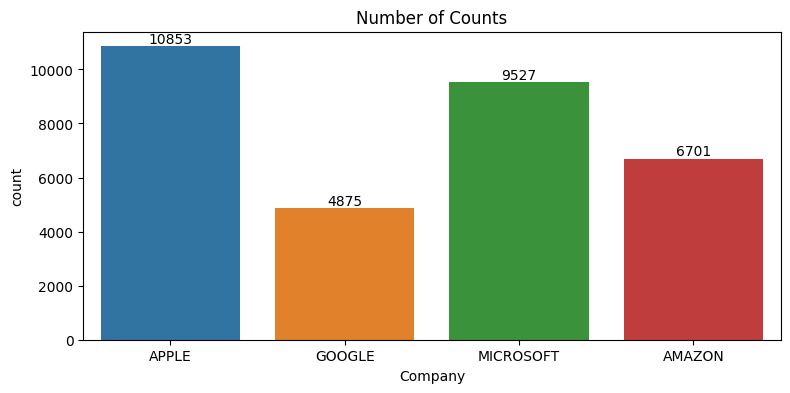

In [32]:
plt.figure(figsize = (9, 4))

ax = sns.countplot(
    data = df, 
    x = 'Company',
    hue = 'Company',
)

for i in ax.containers:
    ax.bar_label(i)

plt.title('Number of Counts')
plt.show()

In [25]:
factor = 'Company'
search_term = 'AMAZON'

filtered_df = df[df[factor] == search_term]

In [ ]:
# Reshape data into a 1D array
# Scale data to the min and max of the rows i.e 0 -1 range
# Flatten the data once again to a 1D array
# ====================================================================

data = filtered_df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
# data_scaled[:10]

In [ ]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, 0]
        label = data[i:i + seq_length, 0]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
seq_length = 1
n_samples = len(data_scaled)
sequences, labels = create_sequences(data_scaled, seq_length)
split = int(0.9 * len(sequences))
X_test, y_test = sequences[split:], labels[split:]
X_train, y_train = sequences[:split], labels[:split]

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model_lstm.add(LSTM(50, activation='relu'))
# model_lstm.add(Dense(320))
model_lstm.add(Dense(200))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
model_lstm.save('model_lstm_7.keras')